# PointNet

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This is an implementation of [PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation]


Part 1 : Object Classification

Shortcut to turn on GPU.


**Runtime** -> **Change runtime type**-> **Hardware accelerator**



In [2]:
import numpy as np
import math
import random
import os
import torch
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import plotly.graph_objects as go
import plotly.express as px

In [3]:
!pip install path.py;
from path import Path

In [4]:
random.seed = 42

Downloading the SHAPENET [dataset](http://3dvision.princeton.edu/projects/2014/3DShapeNets/) directly to the Google Colab Runtime. It comprises 10 categories, 3,991 models for training and 908 for testing.

In [5]:
!wget http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip

--2024-01-03 05:48:59--  http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Resolving 3dvision.princeton.edu (3dvision.princeton.edu)... 128.112.136.67
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.67|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip [following]
--2024-01-03 05:48:59--  https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473402300 (451M) [application/zip]
Saving to: ‘ModelNet10.zip’

ModelNet10.zip      100%[===================>] 451.47M  41.4MB/s    in 12s     

2024-01-03 05:49:11 (39.2 MB/s) - ‘ModelNet10.zip’ saved [473402300/473402300]



In [6]:
!unzip -q ModelNet10.zip;

In [78]:
path = Path("ModelNet10")

In [79]:
folders = [dir for dir in sorted(os.listdir(path)) if os.path.isdir(path/dir)]
classes = {folder: i for i, folder in enumerate(folders)};
classes

{'bathtub': 0,
 'bed': 1,
 'chair': 2,
 'desk': 3,
 'dresser': 4,
 'monitor': 5,
 'night_stand': 6,
 'sofa': 7,
 'table': 8,
 'toilet': 9}

This dataset consists of **.off** files that contain meshes represented by *vertices* and *triangular faces*.



In [80]:
def read_off(file):
    if 'OFF' != file.readline().strip():
        raise('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces

In [81]:
with open(path/"bed/train/bed_0001.off", 'r') as f:
  verts, faces = read_off(f)

In [82]:
i,j,k = np.array(faces).T
x,y,z = np.array(verts).T

In [83]:
len(x)

2095

Function to display animated rotation of meshes and point clouds.

In [84]:
def visualize_rotate(data):
    x_eye, y_eye, z_eye = 1.25, 1.25, 0.8
    frames=[]

    def rotate_z(x, y, z, theta):
        w = x+1j*y
        return np.real(np.exp(1j*theta)*w), np.imag(np.exp(1j*theta)*w), z

    for t in np.arange(0, 10.26, 0.1):
        xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
        frames.append(dict(layout=dict(scene=dict(camera=dict(eye=dict(x=xe, y=ye, z=ze))))))
    fig = go.Figure(data=data,
                    layout=go.Layout(
                        updatemenus=[dict(type='buttons',
                                    showactive=False,
                                    y=1,
                                    x=0.8,
                                    xanchor='left',
                                    yanchor='bottom',
                                    pad=dict(t=45, r=10),
                                    buttons=[dict(label='Play',
                                                    method='animate',
                                                    args=[None, dict(frame=dict(duration=50, redraw=True),
                                                                    transition=dict(duration=0),
                                                                    fromcurrent=True,
                                                                    mode='immediate'
                                                                    )]
                                                    )
                                            ]
                                    )
                                ]
                    ),
                    frames=frames
            )

    return fig

In [85]:
visualize_rotate([go.Mesh3d(x=x, y=y, z=z, color='lightpink', opacity=0.50, i=i,j=j,k=k)]).show()

This mesh definitely looks like a bed.

In [76]:
visualize_rotate([go.Scatter3d(x=x, y=y, z=z,
                                   mode='markers')]).show()

Unfortunately, that's not the case for its vertices. It would be difficult for PointNet to classify point clouds like this one.

Function to accurately visualize point clouds so we could see vertices better.

In [16]:
def pcshow(xs,ys,zs):
    data=[go.Scatter3d(x=xs, y=ys, z=zs,
                                   mode='markers')]
    fig = visualize_rotate(data)
    fig.update_traces(marker=dict(size=2,
                      line=dict(width=2,
                      color='DarkSlateGrey')),
                      selector=dict(mode='markers'))
    fig.show()


In [75]:
pcshow(x,y,z)

## Transforms

Function to sample points on the surface uniformly.

 ### Sample points

In [18]:
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size

    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        # barycentric coordinates on a triangle
        # https://mathworld.wolfram.com/BarycentricCoordinates.html
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))


    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]],
                                           verts[faces[i][1]],
                                           verts[faces[i][2]]))

        sampled_faces = (random.choices(faces,
                                      weights=areas,
                                      cum_weights=None,
                                      k=self.output_size))

        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
                                                   verts[sampled_faces[i][1]],
                                                   verts[sampled_faces[i][2]]))

        return sampled_points


In [19]:
pointcloud = PointSampler(3000)((verts, faces))

In [74]:
pcshow(*pointcloud.T)

This pointcloud looks much more like a bed!

### Normalize

Unit sphere

In [21]:
class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0)
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

In [67]:
norm_pointcloud = Normalize()(pointcloud)

In [73]:
pcshow(*norm_pointcloud.T)

The axis limits have changed.

### Augmentations

Adding *random rotation* of the whole pointcloud and random noise to its points.

In [24]:
class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])

        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return  rot_pointcloud

class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.02, (pointcloud.shape))

        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud

In [25]:
rot_pointcloud = RandRotation_z()(norm_pointcloud)
noisy_rot_pointcloud = RandomNoise()(rot_pointcloud)

### ToTensor

In [26]:
class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        return torch.from_numpy(pointcloud)

In [27]:
ToTensor()(noisy_rot_pointcloud)

tensor([[-0.2329, -0.4307, -0.1000],
        [-0.2679,  0.0063,  0.1712],
        [-0.1850, -0.4088,  0.1311],
        ...,
        [-0.0564,  0.5004, -0.1289],
        [-0.2130, -0.4751,  0.3145],
        [-0.1074, -0.1152,  0.1595]], dtype=torch.float64)

In [28]:
def default_transforms():
    return transforms.Compose([
                                PointSampler(1024),
                                Normalize(),
                                ToTensor()
                              ])

## Dataset

Creating a [custom PyTorch Dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

In [29]:
class PointCloudData(Dataset):
    def __init__(self, root_dir, valid=False, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        verts, faces = read_off(file)
        if self.transforms:
            pointcloud = self.transforms((verts, faces))
        return pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            pointcloud = self.__preproc__(f)
        return {'pointcloud': pointcloud,
                'category': self.classes[category]}

Transforms for training. 1024 points per cloud.

In [30]:
train_transforms = transforms.Compose([
                    PointSampler(1024),
                    Normalize(),
                    RandRotation_z(),
                    RandomNoise(),
                    ToTensor()
                    ])

In [31]:
train_ds = PointCloudData(path, transform=train_transforms)
valid_ds = PointCloudData(path, valid=True, folder='test', transform=train_transforms)

In [32]:
inv_classes = {i: cat for cat, i in train_ds.classes.items()};
inv_classes

{0: 'bathtub',
 1: 'bed',
 2: 'chair',
 3: 'desk',
 4: 'dresser',
 5: 'monitor',
 6: 'night_stand',
 7: 'sofa',
 8: 'table',
 9: 'toilet'}

In [33]:
print('Train dataset size: ', len(train_ds))
print('Valid dataset size: ', len(valid_ds))
print('Number of classes: ', len(train_ds.classes))
print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())
print('Class: ', inv_classes[train_ds[0]['category']])

Train dataset size:  3991
Valid dataset size:  908
Number of classes:  10
Sample pointcloud shape:  torch.Size([1024, 3])
Class:  bathtub


In [34]:
train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=64)

## Model

In [35]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class Tnet(nn.Module):
   def __init__(self, k=3):
      super().__init__()
      self.k=k
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,1024,1)
      self.fc1 = nn.Linear(1024,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)

      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(1024)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)


   def forward(self, input):
      # input.shape == (bs,n,3)
      bs = input.size(0)
      xb = F.relu(self.bn1(self.conv1(input)))
      xb = F.relu(self.bn2(self.conv2(xb)))
      xb = F.relu(self.bn3(self.conv3(xb)))
      pool = nn.MaxPool1d(xb.size(-1))(xb)
      flat = nn.Flatten(1)(pool)
      xb = F.relu(self.bn4(self.fc1(flat)))
      xb = F.relu(self.bn5(self.fc2(xb)))

      #initialize as identity
      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
      if xb.is_cuda:
        init=init.cuda()
      matrix = self.fc3(xb).view(-1,self.k,self.k) + init
      return matrix


class Transform(nn.Module):
   def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)


        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)

   def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 10):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)


        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

In [36]:
def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

## Training loop

In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [38]:
pointnet = PointNet()
pointnet.to(device);

In [39]:
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001)

In [40]:
def train(model, train_loader, val_loader=None,  epochs=15, save=True):
    for epoch in range(epochs):
        pointnet.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = pointnet(inputs.transpose(1,2))

            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches
                    print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                        (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                    running_loss = 0.0

        pointnet.eval()
        correct = total = 0

        # validation
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs, __, __ = pointnet(inputs.transpose(1,2))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print('Valid accuracy: %d %%' % val_acc)

        # save the model
        if save:
            torch.save(pointnet.state_dict(), "save_"+str(epoch)+".pth")

In [ ]:
train(pointnet, train_loader, valid_loader,  save=False)

[Epoch: 1, Batch:   10 /  125], loss: 1.994
[Epoch: 1, Batch:   20 /  125], loss: 1.618
[Epoch: 1, Batch:   30 /  125], loss: 1.503
[Epoch: 1, Batch:   40 /  125], loss: 1.224
[Epoch: 1, Batch:   50 /  125], loss: 1.041
[Epoch: 1, Batch:   60 /  125], loss: 1.161
[Epoch: 1, Batch:   70 /  125], loss: 0.980
[Epoch: 1, Batch:   80 /  125], loss: 1.039
[Epoch: 1, Batch:   90 /  125], loss: 1.047
[Epoch: 1, Batch:  100 /  125], loss: 0.865
[Epoch: 1, Batch:  110 /  125], loss: 0.919
[Epoch: 1, Batch:  120 /  125], loss: 0.878
Valid accuracy: 68 %


KeyboardInterrupt: ignored

## Test

In [41]:
from sklearn.metrics import confusion_matrix

In [43]:
pointnet = PointNet()
pointnet.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/save.pth'))
pointnet.eval();

In [44]:
all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(valid_loader):
        print('Batch [%4d / %4d]' % (i+1, len(valid_loader)))

        inputs, labels = data['pointcloud'].float(), data['category']
        outputs, __, __ = pointnet(inputs.transpose(1,2))
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())



Batch [   1 /   15]
Batch [   2 /   15]
Batch [   3 /   15]
Batch [   4 /   15]
Batch [   5 /   15]
Batch [   6 /   15]
Batch [   7 /   15]
Batch [   8 /   15]
Batch [   9 /   15]
Batch [  10 /   15]
Batch [  11 /   15]
Batch [  12 /   15]
Batch [  13 /   15]
Batch [  14 /   15]
Batch [  15 /   15]


In [45]:
cm = confusion_matrix(all_labels, all_preds);
cm

array([[ 41,   9,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1,  96,   2,   0,   0,   0,   0,   1,   0,   0],
       [  0,   0, 100,   0,   0,   0,   0,   0,   0,   0],
       [  1,   2,   2,  30,   5,   0,  19,   5,  21,   1],
       [  0,   0,   0,   0,  38,   0,  47,   0,   1,   0],
       [  0,   0,   1,   0,  26,  70,   2,   1,   0,   0],
       [  0,   0,   1,   0,   7,   0,  77,   0,   1,   0],
       [  0,   1,   1,   0,   1,   0,   1,  96,   0,   0],
       [  0,   0,   0,   6,   0,   0,   1,   0,  93,   0],
       [  1,   0,  14,   0,   1,   0,   2,   1,   1,  80]])

In [46]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


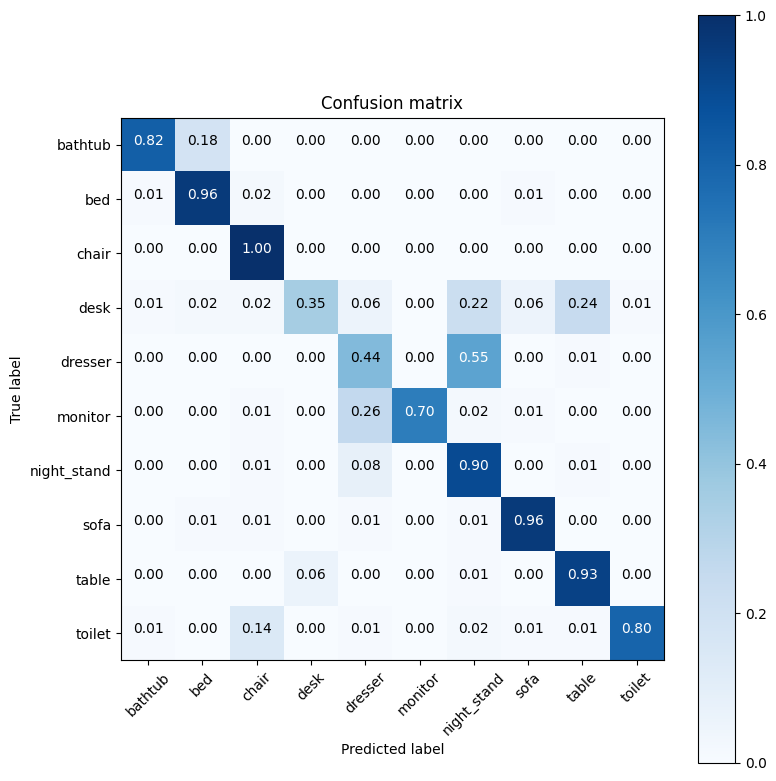

In [47]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=True)

Confusion matrix, without normalization


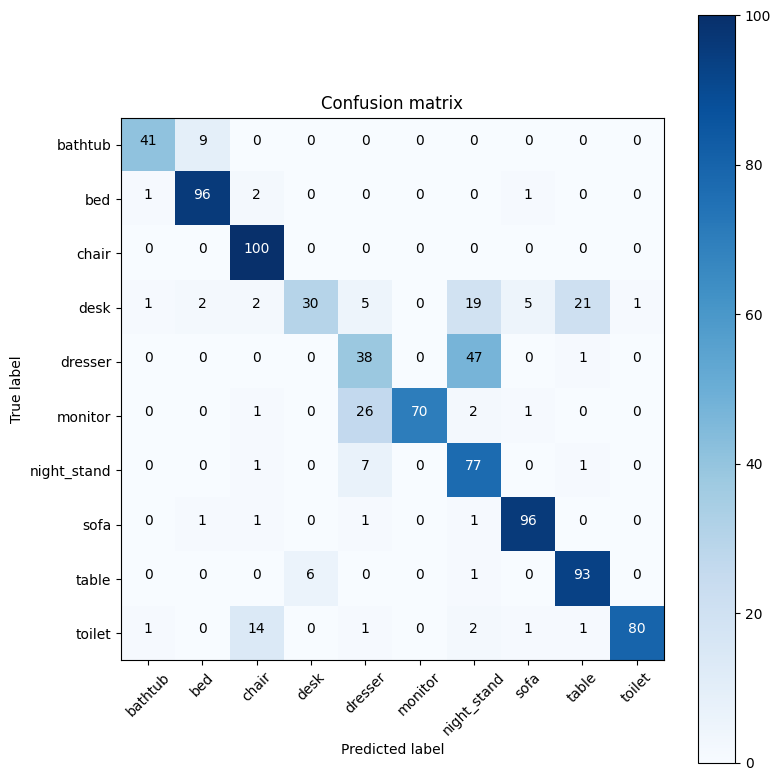

In [48]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=False)

Performance Analysing Metrics

In [69]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 79.41%


In [50]:
from sklearn.metrics import precision_score

precision = precision_score(all_labels, all_preds, average='weighted')
print(f'Precision: {precision * 100:.2f}%')


Precision: 82.23%


In [51]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
y_true = all_labels
y_pred = all_preds
# Compute accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Compute precision
precision = precision_score(y_true, y_pred, average='weighted')  # 'weighted' for multi-class
print(f"Precision: {precision:.4f}")

# Compute recall
recall = recall_score(y_true, y_pred, average='weighted')  # 'weighted' for multi-class
print(f"Recall: {recall:.4f}")

# Compute F1 score
f1 = f1_score(y_true, y_pred, average='weighted')  # 'weighted' for multi-class
print(f"F1 Score: {f1:.4f}")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.7941
Precision: 0.8223
Recall: 0.7941
F1 Score: 0.7880
Confusion Matrix:
[[ 41   9   0   0   0   0   0   0   0   0]
 [  1  96   2   0   0   0   0   1   0   0]
 [  0   0 100   0   0   0   0   0   0   0]
 [  1   2   2  30   5   0  19   5  21   1]
 [  0   0   0   0  38   0  47   0   1   0]
 [  0   0   1   0  26  70   2   1   0   0]
 [  0   0   1   0   7   0  77   0   1   0]
 [  0   1   1   0   1   0   1  96   0   0]
 [  0   0   0   6   0   0   1   0  93   0]
 [  1   0  14   0   1   0   2   1   1  80]]


In [70]:
inv_classes

{0: 'bathtub',
 1: 'bed',
 2: 'chair',
 3: 'desk',
 4: 'dresser',
 5: 'monitor',
 6: 'night_stand',
 7: 'sofa',
 8: 'table',
 9: 'toilet'}

In [59]:
objects_mapping = {
    'object_1': ['bathtub'],
    'object_2': ['bed'],
    'object_3': ['chair'],
    'object_4': ['desk'],
    'object_5': ['dresser'],
    'object_6': ['monitor'],
    'object_7': ['night_stand'],
    'object_8': ['sofa'],
    'object_9': ['table'],
    'object_10': ['toilet']
}


In [60]:
object_wise_data = {obj: {'true_labels': [], 'predicted_labels': []} for obj in objects_mapping}

for obj, classes in objects_mapping.items():
    obj_classes_indices = [classes.index(cls) for cls in classes]
    # Extract rows and columns corresponding to classes of the object from the confusion matrix
    obj_cm = cm[np.ix_(obj_classes_indices, obj_classes_indices)]
    obj_true_labels = np.sum(obj_cm, axis=1)
    obj_predicted_labels = np.sum(obj_cm, axis=0)
    object_wise_data[obj]['true_labels'] = obj_true_labels
    object_wise_data[obj]['predicted_labels'] = obj_predicted_labels

# Now, object_wise_data contains true labels and predicted labels for each object.

In [61]:
from sklearn.metrics import accuracy_score

object_wise_accuracy = {}

for obj, data in object_wise_data.items():
    true_labels = data['true_labels']
    predicted_labels = data['predicted_labels']
    accuracy = accuracy_score(true_labels, predicted_labels)
    object_wise_accuracy[obj] = accuracy

# Print or use object_wise_accuracy dictionary for further analysis
print(object_wise_accuracy)


{'object_1': 1.0, 'object_2': 1.0, 'object_3': 1.0, 'object_4': 1.0, 'object_5': 1.0, 'object_6': 1.0, 'object_7': 1.0, 'object_8': 1.0, 'object_9': 1.0, 'object_10': 1.0}


In [62]:
for obj, classes in objects_mapping.items():
    print(f"{obj}: {classes}")

object_1: ['bathtub']
object_2: ['bed']
object_3: ['chair']
object_4: ['desk']
object_5: ['dresser']
object_6: ['monitor']
object_7: ['night_stand']
object_8: ['sofa']
object_9: ['table']
object_10: ['toilet']


In [63]:
objects_mapping

{'object_1': ['bathtub'],
 'object_2': ['bed'],
 'object_3': ['chair'],
 'object_4': ['desk'],
 'object_5': ['dresser'],
 'object_6': ['monitor'],
 'object_7': ['night_stand'],
 'object_8': ['sofa'],
 'object_9': ['table'],
 'object_10': ['toilet']}

In [64]:
object_wise_preds = {f"object_{i+1}": [] for i in range(10)}
object_wise_labels = {f"object_{i+1}": [] for i in range(10)}

with torch.no_grad():
    for i, data in enumerate(valid_loader):
        print('Batch [%4d / %4d]' % (i+1, len(valid_loader)))

        inputs, labels = data['pointcloud'].float(), data['category']
        outputs, __, __ = pointnet(inputs.transpose(1, 2))
        _, preds = torch.max(outputs.data, 1)

        preds = list(preds.numpy())
        labels = list(labels.numpy())

        for obj_idx in range(len(labels)):
            object_wise_preds[f"object_{labels[obj_idx]+1}"].append(preds[obj_idx])
            object_wise_labels[f"object_{labels[obj_idx]+1}"].append(labels[obj_idx])


Batch [   1 /   15]
Batch [   2 /   15]
Batch [   3 /   15]
Batch [   4 /   15]
Batch [   5 /   15]
Batch [   6 /   15]
Batch [   7 /   15]
Batch [   8 /   15]
Batch [   9 /   15]
Batch [  10 /   15]
Batch [  11 /   15]
Batch [  12 /   15]
Batch [  13 /   15]
Batch [  14 /   15]
Batch [  15 /   15]


In [66]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize dictionaries to store metrics for each object
object_wise_accuracy = {}
object_wise_precision = {}
object_wise_recall = {}
object_wise_f1 = {}

# Iterate through objects and calculate metrics
for obj in object_wise_preds.keys():
    preds = object_wise_preds[obj]
    labels = object_wise_labels[obj]

    # Compute accuracy
    accuracy = accuracy_score(labels, preds)
    object_wise_accuracy[obj] = accuracy

    # Compute precision
    precision = precision_score(labels, preds, average='weighted', zero_division=0)
    object_wise_precision[obj] = precision

    # Compute recall
    recall = recall_score(labels, preds, average='weighted', zero_division=0)
    object_wise_recall[obj] = recall

    # Compute F1 score
    f1 = f1_score(labels, preds, average='weighted', zero_division=0)
    object_wise_f1[obj] = f1

# Print metrics for each object
for obj in object_wise_preds.keys():
    print(f"Object {objects_mapping[obj][0]}:")
    print(f"  Accuracy: {object_wise_accuracy[obj]:.4f}")
    print(f"  Precision: {object_wise_precision[obj]:.4f}")
    print(f"  Recall: {object_wise_recall[obj]:.4f}")
    print(f"  F1 Score: {object_wise_f1[obj]:.4f}")
    print()


Object bathtub:
  Accuracy: 0.8000
  Precision: 1.0000
  Recall: 0.8000
  F1 Score: 0.8889

Object bed:
  Accuracy: 0.9700
  Precision: 1.0000
  Recall: 0.9700
  F1 Score: 0.9848

Object chair:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000

Object desk:
  Accuracy: 0.3721
  Precision: 1.0000
  Recall: 0.3721
  F1 Score: 0.5424

Object dresser:
  Accuracy: 0.4767
  Precision: 1.0000
  Recall: 0.4767
  F1 Score: 0.6457

Object monitor:
  Accuracy: 0.7100
  Precision: 1.0000
  Recall: 0.7100
  F1 Score: 0.8304

Object night_stand:
  Accuracy: 0.9535
  Precision: 1.0000
  Recall: 0.9535
  F1 Score: 0.9762

Object sofa:
  Accuracy: 0.9700
  Precision: 1.0000
  Recall: 0.9700
  F1 Score: 0.9848

Object table:
  Accuracy: 0.9300
  Precision: 1.0000
  Recall: 0.9300
  F1 Score: 0.9637

Object toilet:
  Accuracy: 0.8100
  Precision: 1.0000
  Recall: 0.8100
  F1 Score: 0.8950



Here's a summary :

"desk":

Low accuracy (38.37%)
Low recall (38.37%)
Low F1 Score (55.46%)
This suggests the model has difficulty correctly identifying instances of the "desk" class, potentially misclassifying them as other classes.

"dresser":

Moderate accuracy (50.00%)
Low recall (50.00%)
Moderate F1 Score (66.67%)
Similar to "desk," the model might have challenges in correctly identifying "dresser" instances.
These lower-performing classes might have imbalanced data or might be visually similar to other classes, leading to confusion for the model in distinguishing them accurately.

To improve performance for these classes, you could consider strategies like:

Data Augmentation: Increase the diversity of "desk" and "dresser" instances in the dataset to help the model learn better representations.
Model Tuning: Adjust model architecture or hyperparameters specifically addressing the characteristics of these challenging classes.
Class Balancing: If the dataset is highly imbalanced, consider techniques like oversampling or undersampling to balance the representation of each class.
These steps might help improve the model's ability to recognize and classify instances of these challenging classes more accurately.

In [72]:
print("Completed")

Completed
